# Belief Networks

Flow of Code:
* Load the Dataset
* Create an Ensemble of Character Recognition Experts (5x) with different accuracies
* Each Expert Reviews Test Set (10,000 images), and provides Accuracy.
* Use Expert Ratings as well as Expect Accuracy to create Belief Network.
* 6th Expert reads in an unseen character and classifies it.
* The Belief Network States which images it is most like.
* The belief network recasts the 6th experts prediction to reflect uncertainty in training data.

## Loading the Dataset - MNIST

In [2]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import csv
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import load_model
from scipy.optimize import minimize



# Importing the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)



## Creating Expert Models using Training Loop

In [85]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import models, layers

# # Random Seed
# np.random.seed(12883)

# # Create the model
# model = models.Sequential([
#     layers.Conv2D(2, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.BatchNormalization(),
#     layers.Conv2D(2, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(2, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(20, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(20, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax')
# ])

# model.summary()

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Training loop to save 10 different models
# for epoch in range(1,11):  # From epoch 1 to 11 gives us 10
#     print(f"Training epoch {epoch}")
#     current_size = int(4096/(2**(epoch-1)))  # Halve the batch size every epoch
#     model.fit(train_images, train_labels, epochs=1, batch_size=current_size, validation_split=0.33) # Train the model for 1 epoch
#     model_path = f"mnist_expert{epoch}.keras"  # Path to save the model
#     model.save(model_path)  # Save the model
#     print(f"Model saved to {model_path}")

#     # Evaluate the model on the test set
#     test_loss, test_acc = model.evaluate(test_images, test_labels)
#     print(f"Test accuracy after epoch {epoch}: {test_acc}")


/Users/christopherwaight/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_162 (Conv2D)             │ (None, 26, 26, 2)      │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 26, 26, 2)      │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_163 (Conv2D)             │ (None, 24, 24, 2)      │            38 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 12, 12, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_164 (Conv2D)             │ (None, 10, 10, 2)      │            38 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_54 (Flatten)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 20)             │         4,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,754 (18.57 KB)

 Trainable params: 4,750 (18.55 KB)

 Non-trainable params: 4 (16.00 B)

Training epoch 11
10050/10050 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.3820 - loss: 1.6726 - val_accuracy: 0.8999 - val_loss: 0.4645
Model saved to mnist_expert11.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8925 - loss: 0.4862
Test accuracy after epoch 11: 0.9052000045776367


## Load Experts

In [73]:
import numpy as np
from tensorflow.keras.models import load_model

# List of model paths
model_paths = [f"mnist_expert{i+1}.keras" for i in range(10)]
scores = []

# Loop to load, evaluate each model and print test accuracy
for i, path in enumerate(model_paths):
    model = load_model(path)  # Load model
    test_loss, test_acc = model.evaluate(test_images, test_labels)  # Evaluate model
    print(f"Test accuracy of Expert {i+1}: {test_acc}")  # Print test accuracy
    scores.append(test_acc)  # Append test accuracy to scores list

print("Scores for all models:", scores)
print("Scores in ascending order:", sorted(scores))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4926 - loss: 2.1434
Test accuracy of Expert 1: 0.5133000016212463
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7133 - loss: 1.3220
Test accuracy of Expert 2: 0.7389000058174133
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6521 - loss: 1.7768
Test accuracy of Expert 3: 0.6784999966621399
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6155 - loss: 1.4973
Test accuracy of Expert 4: 0.6524999737739563
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8506 - loss: 0.6878
Test accuracy of Expert 5: 0.8701000213623047
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8963 - loss: 0.5285
Test accuracy of Expert 6: 0.909600019454956
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9368 - loss: 0.2546
Test accuracy of Expert 7: 0.9473999738693237
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5654 - loss: 2.0887
Test accuracy of Expert 8: 0.5684999823570251
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1

## Asking Each Expert to rate 10,000 images

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


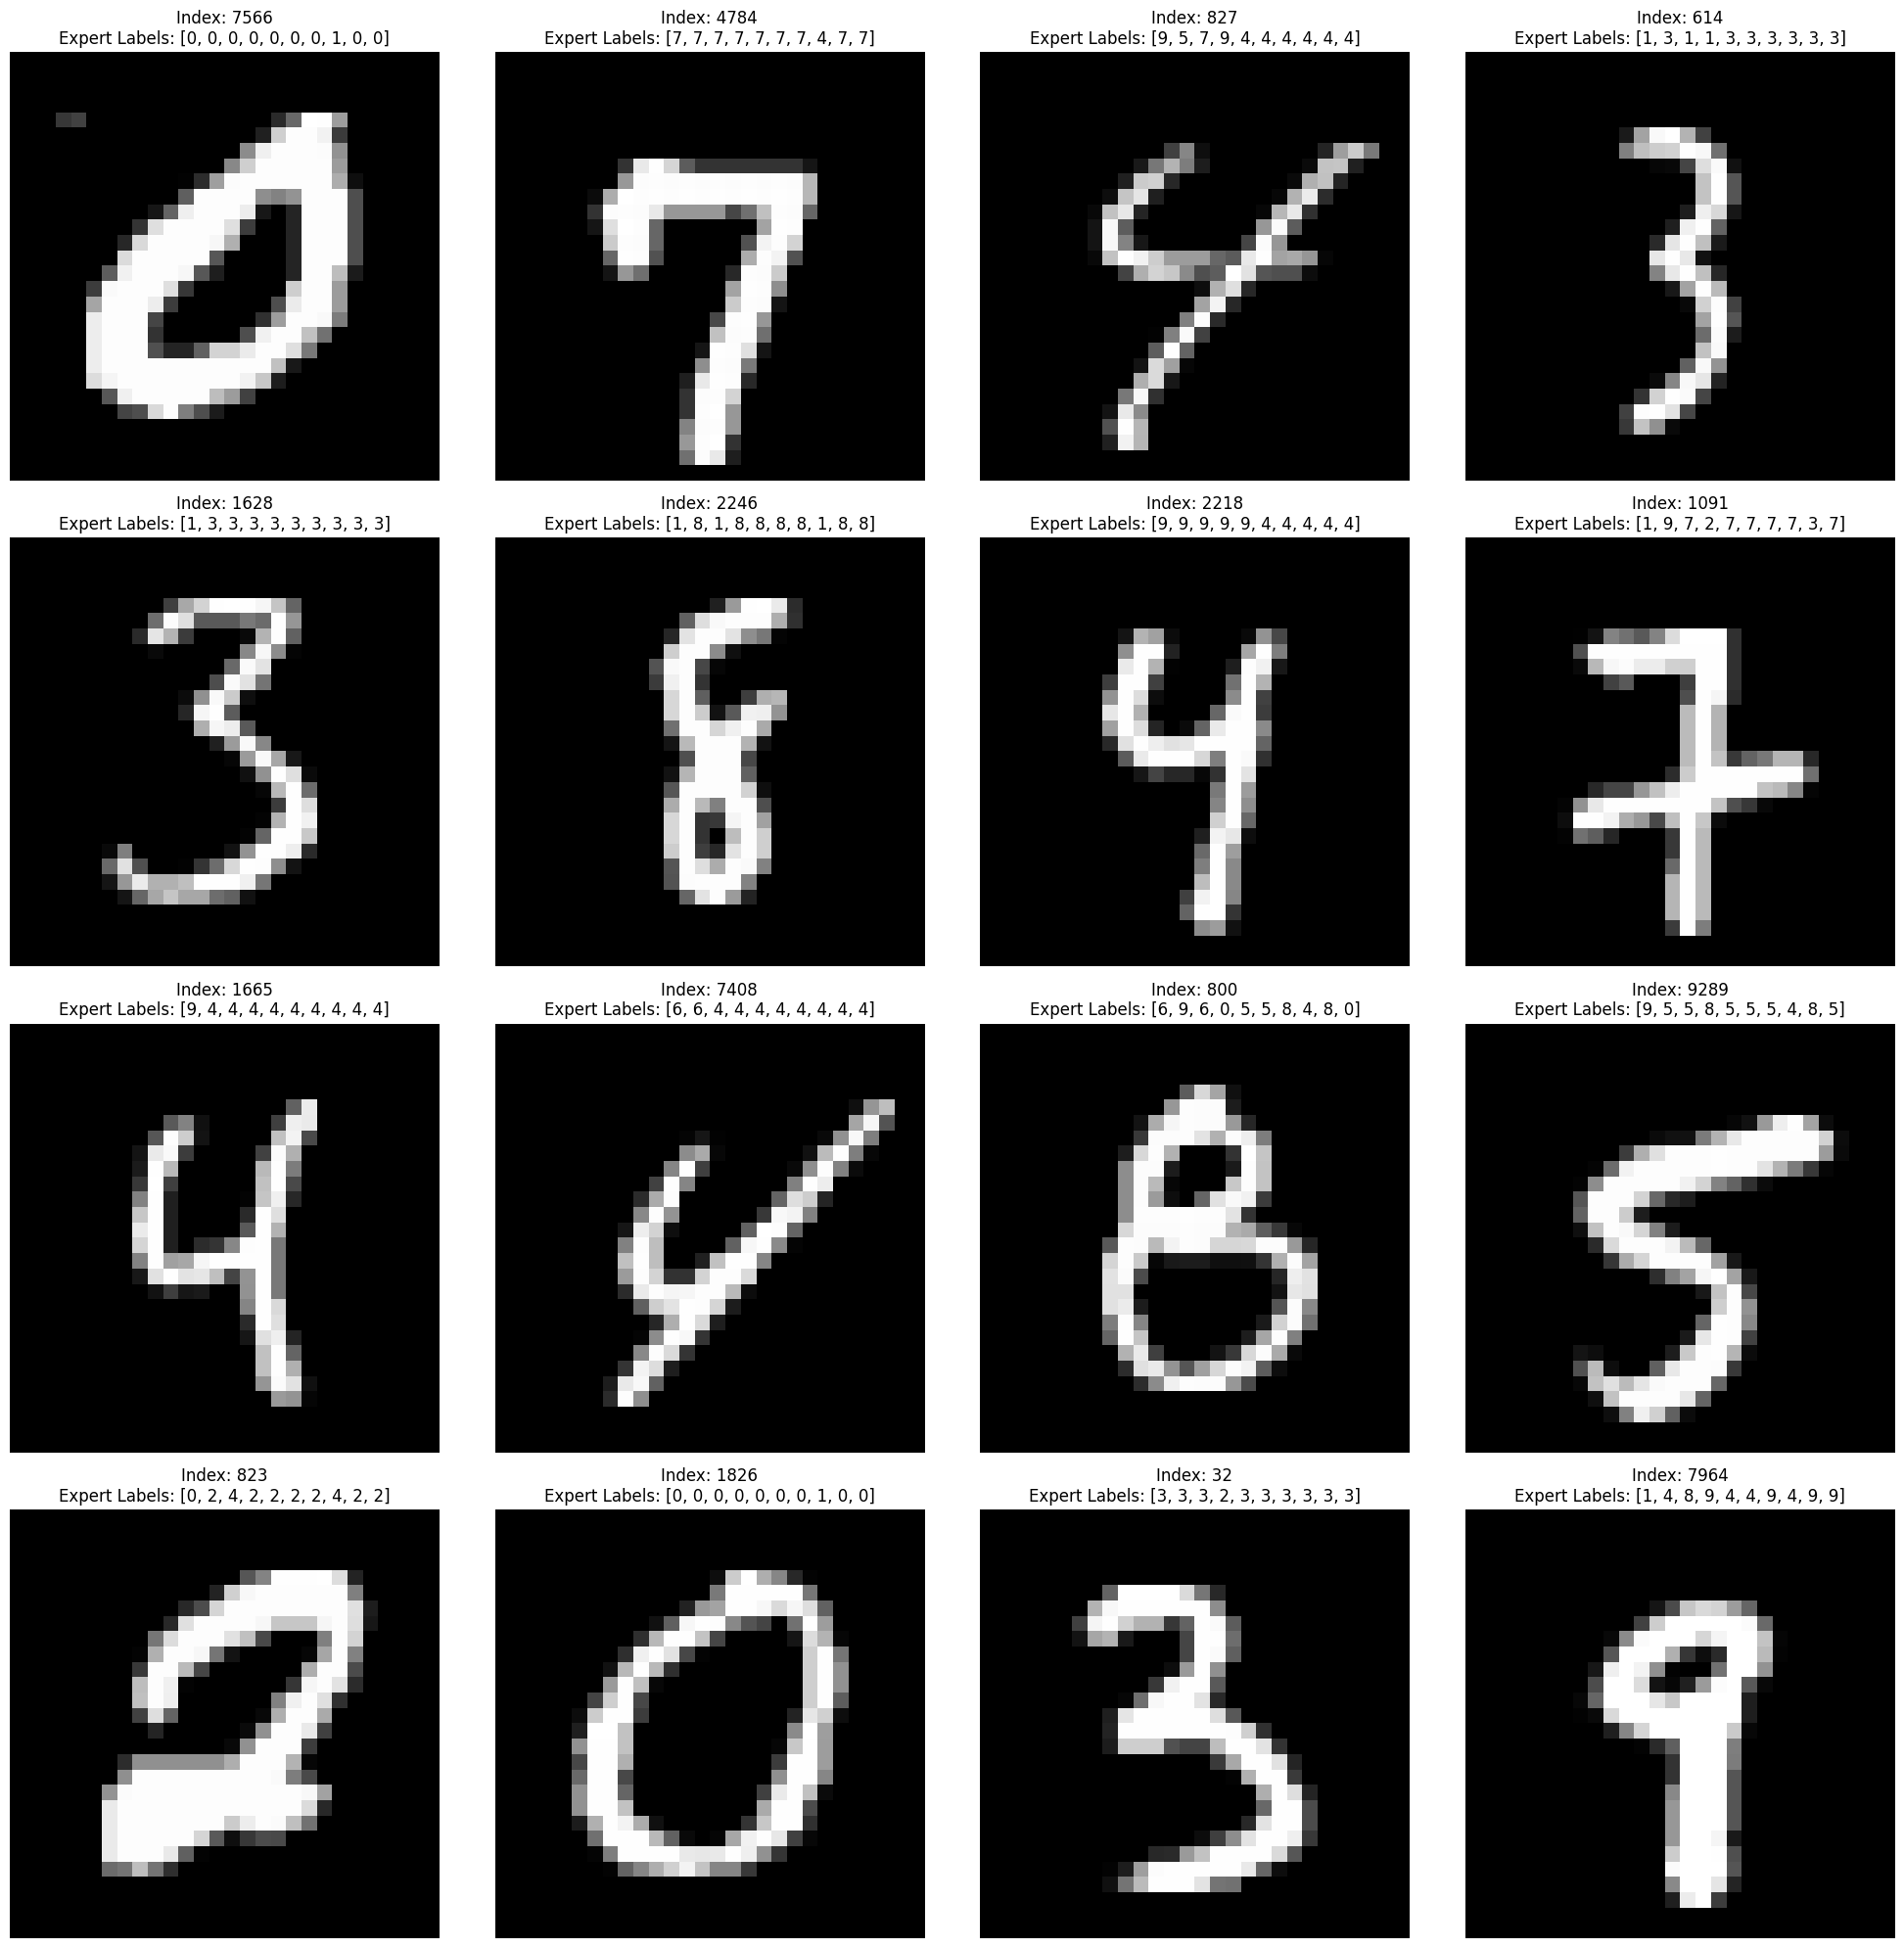

Index: 7566
Model 1 prediction: 0, softmax output: 0.12922443449497223
Model 2 prediction: 0, softmax output: 0.4194532334804535
Model 3 prediction: 0, softmax output: 0.1651795655488968
Model 4 prediction: 0, softmax output: 0.4922453463077545
Model 5 prediction: 0, softmax output: 0.995274543762207
Model 6 prediction: 0, softmax output: 0.9982955455780029
Model 7 prediction: 0, softmax output: 0.9981669187545776
Model 8 prediction: 1, softmax output: 0.11764773726463318
Model 9 prediction: 0, softmax output: 0.9955305457115173
Model 10 prediction: 0, softmax output: 0.9996560215950012
Index: 4784
Model 1 prediction: 7, softmax output: 0.1405142843723297
Model 2 prediction: 7, softmax output: 0.4795691668987274
Model 3 prediction: 7, softmax output: 0.25255638360977173
Model 4 prediction: 7, softmax output: 0.4926462471485138
Model 5 prediction: 7, softmax output: 0.7513629794120789
Model 6 prediction: 7, softmax output: 0.7804170846939087
Model 7 prediction: 7, softmax output: 0.7048

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load models and get predictions
num_models = 10  # Specify the number of models
predictions = []
predicted_classes = []

for i in range(1, num_models + 1):
    model = load_model(f"mnist_expert{i}.keras")  # Load each model
    pred = model.predict(test_images)  # Predict with the model
    predictions.append(pred)
    predicted_classes.append(np.argmax(pred, axis=1))  # Convert softmax to class predictions

# True classes
true_classes = np.argmax(test_labels, axis=1)

# Identify misclassified examples for each model
misclassified_by_model = [np.where(pred_classes != true_classes)[0] for pred_classes in predicted_classes]

# Count misclassifications for each image
misclassification_counts = {}
for model_misclassified_indices in misclassified_by_model:
    for index in model_misclassified_indices:
        misclassification_counts[index] = misclassification_counts.get(index, 0) + 1

# Sort indices by the number of times they were misclassified, in descending order
sorted_misclassified_indices = sorted(misclassification_counts, key=misclassification_counts.get, reverse=True)

# Display 16 random images from misclassified indices in a 4x4 grid
random_misclassified_indices = np.random.choice(sorted_misclassified_indices, 16, replace=False)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for ax, index in zip(axes.flatten(), random_misclassified_indices):
    ax.imshow(test_images[index].reshape(28, 28), cmap='gray')
    predictions_for_plot = [predicted_classes[i][index] for i in range(num_models)]  # Predictions from all models for this index
    ax.set_title(f"Index: {index}\nExpert Labels: {predictions_for_plot}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print prediction and softmax output for each randomly selected misclassified index
for index in random_misclassified_indices:
    print(f"Index: {index}")
    for i in range(num_models):
        print(f"Model {i+1} prediction: {predicted_classes[i][index]}, softmax output: {np.max(predictions[i][index])}")


## Asking Each Expert to rate 100 images

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


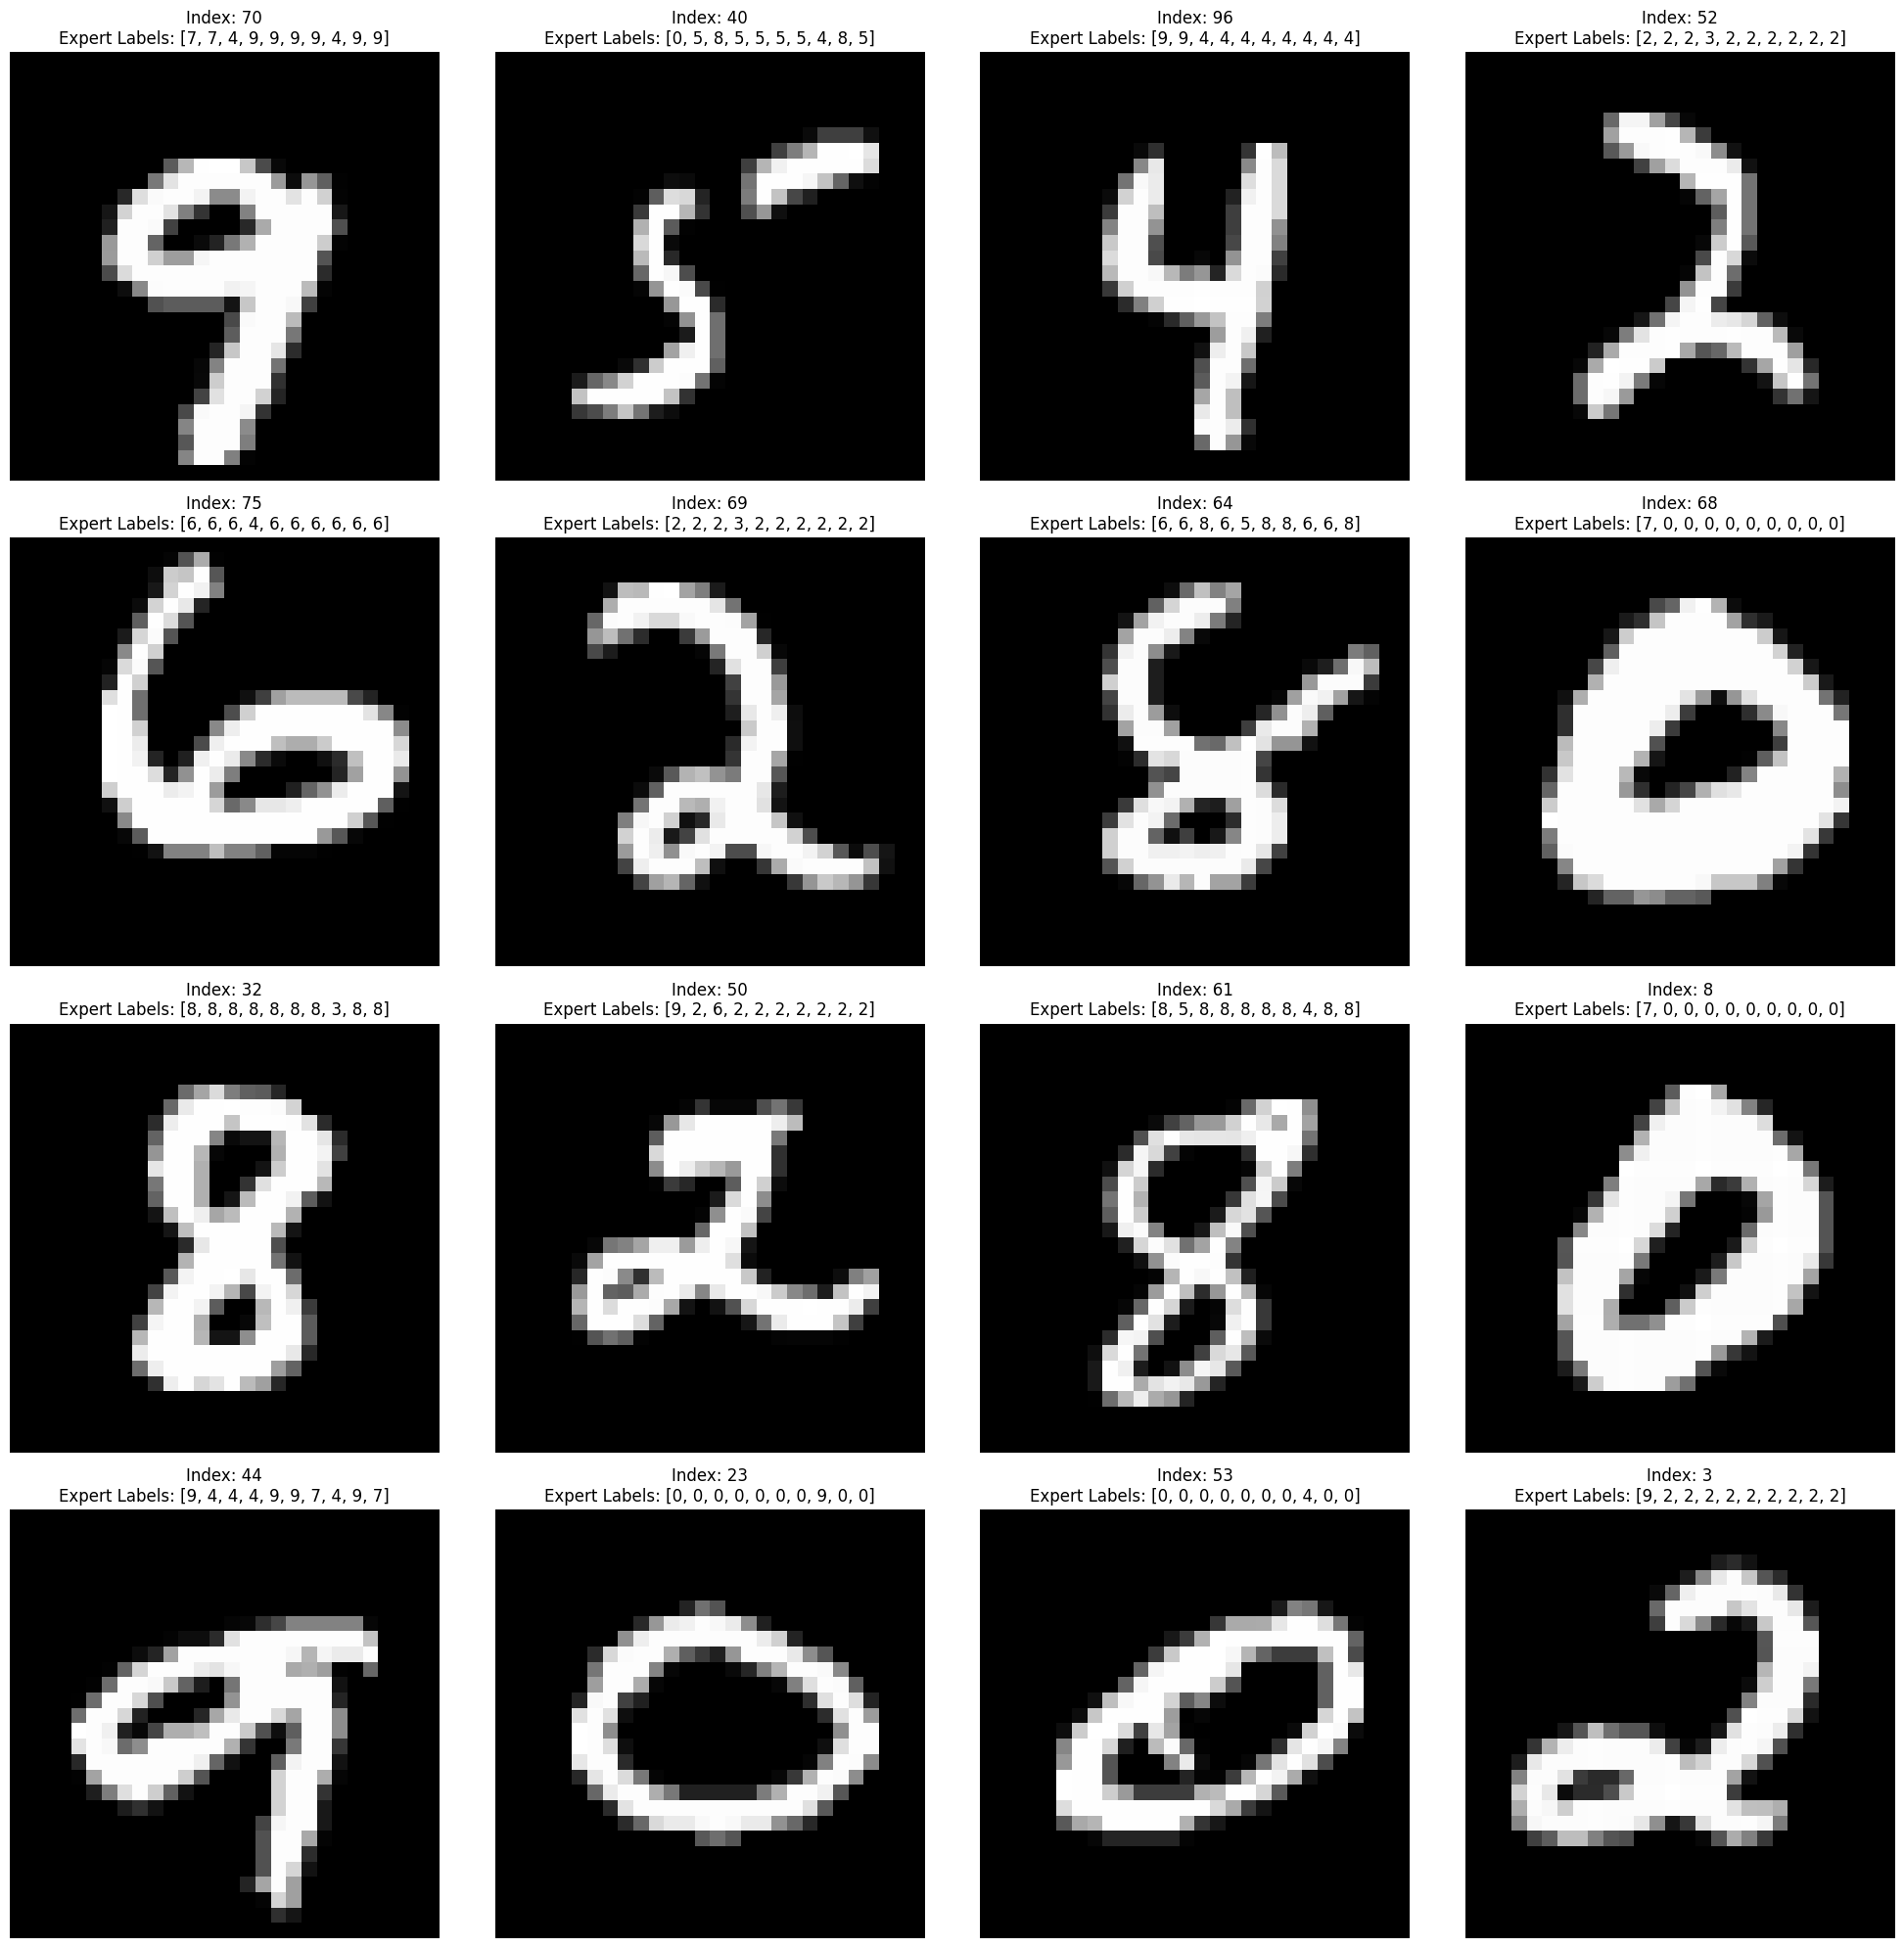

Index: 70
Model 1 prediction: 7, softmax output: 0.11872366070747375
Model 2 prediction: 7, softmax output: 0.26857614517211914
Model 3 prediction: 4, softmax output: 0.12820345163345337
Model 4 prediction: 9, softmax output: 0.3821365535259247
Model 5 prediction: 9, softmax output: 0.5597029328346252
Model 6 prediction: 9, softmax output: 0.7087103128433228
Model 7 prediction: 9, softmax output: 0.9483256936073303
Model 8 prediction: 4, softmax output: 0.1402130275964737
Model 9 prediction: 9, softmax output: 0.9486335515975952
Model 10 prediction: 9, softmax output: 0.9776139259338379
Index: 40
Model 1 prediction: 0, softmax output: 0.10768169909715652
Model 2 prediction: 5, softmax output: 0.186758890748024
Model 3 prediction: 8, softmax output: 0.11697709560394287
Model 4 prediction: 5, softmax output: 0.17540952563285828
Model 5 prediction: 5, softmax output: 0.5334733128547668
Model 6 prediction: 5, softmax output: 0.8991885185241699
Model 7 prediction: 5, softmax output: 0.97419

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# True classes from the full test_labels
true_classes_full = np.argmax(test_labels, axis=1)

# Create a balanced subset of 100 images, ensuring each digit 0-9 is represented equally
indices_per_class = 10  # Number of indices per class to achieve 100 images total
selected_indices = []

for digit in range(10):
    digit_indices = np.where(true_classes_full == digit)[0]
    selected_digit_indices = np.random.choice(digit_indices, indices_per_class, replace=False)
    selected_indices.extend(selected_digit_indices)

# Ensure the selected indices are shuffled to mix the digits
np.random.shuffle(selected_indices)

# Slicing the test_images and test_labels to get only the selected subset
subset_test_images = test_images[selected_indices]
subset_test_labels = test_labels[selected_indices]

# Load models and get predictions
num_models = 10  # Specify the number of models
predictions = []
predicted_classes = []

for i in range(1, num_models + 1):
    model = load_model(f"mnist_expert{i}.keras")  # Load each model
    pred = model.predict(subset_test_images)  # Predict with the model on the subset
    predictions.append(pred)
    predicted_classes.append(np.argmax(pred, axis=1))  # Convert softmax to class predictions

# True classes for the subset
true_classes = np.argmax(subset_test_labels, axis=1)

# Identify misclassified examples for each model
misclassified_by_model = [np.where(pred_classes != true_classes)[0] for pred_classes in predicted_classes]

# Count misclassifications for each image in the subset
misclassification_counts = {}
for model_misclassified_indices in misclassified_by_model:
    for index in model_misclassified_indices:
        misclassification_counts[index] = misclassification_counts.get(index, 0) + 1

# Sort indices by the number of times they were misclassified, in descending order
sorted_misclassified_indices = sorted(misclassification_counts, key=misclassification_counts.get, reverse=True)

# Display 16 random images from misclassified indices in a 4x4 grid
random_misclassified_indices = np.random.choice(sorted_misclassified_indices, 16, replace=False)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

for ax, index in zip(axes.flatten(), random_misclassified_indices):
    ax.imshow(subset_test_images[index].reshape(28, 28), cmap='gray')
    predictions_for_plot = [predicted_classes[i][index] for i in range(num_models)]  # Predictions from all models for this index
    ax.set_title(f"Index: {index}\nExpert Labels: {predictions_for_plot}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print prediction and softmax output for each randomly selected misclassified index
for index in random_misclassified_indices:
    print(f"Index: {index}")
    for i in range(num_models):
        print(f"Model {i+1} prediction: {predicted_classes[i][index]}, softmax output: {np.max(predictions[i][index])}")


## Creating that spreadsheet that was Requested



In [84]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# True classes from the full test_labels
true_classes_full = np.argmax(test_labels, axis=1)

# Create a balanced subset of 100 images, ensuring each digit 0-9 is represented equally
indices_per_class = 10  # Number of indices per class to achieve 100 images total
selected_indices = []

for digit in range(10):
    digit_indices = np.where(true_classes_full == digit)[0]
    selected_digit_indices = np.random.choice(digit_indices, indices_per_class, replace=False)
    selected_indices.extend(selected_digit_indices)

# Ensure the selected indices are shuffled to mix the digits
np.random.shuffle(selected_indices)

# Slicing the test_images and test_labels to get only the selected subset
subset_test_images = test_images[selected_indices]
subset_test_labels = test_labels[selected_indices]

# Load models and get predictions
num_models = 10  # Specify the number of models
predictions = []

for i in range(1, num_models + 1):
    model = load_model(f"mnist_expert{i}.keras")  # Load each model
    pred = model.predict(subset_test_images)  # Predict with the model on the subset
    predictions.append(pred)

# Open a text file for writing results
with open('prediction_results.txt', 'w') as file:
    # Write header
    file.write("Image Index, Model Number, Predicted Class, Softmax Output\n")
    
    # For each model, write prediction results for each image
    for i in range(num_models):
        for j in range(len(subset_test_images)):
            predicted_class = np.argmax(predictions[i][j])
            softmax_output = np.max(predictions[i][j])
            expert_accuracy = scores[i]
            # Write to file
            file.write(f"{j}, Expert {i+1}, {expert_accuracy:.4f}, {predicted_class}, {softmax_output:.4f}\n")

print("Prediction results have been written to 'prediction_results.txt'.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction results have been written to 'prediction_results.txt'.


In [27]:
# For each Image Index
#     For each Model/Classifier
#         Print the Scaled Confidence Score of each possible class (Confidence Score * the model's accuracy)
#         Calculate the Scaled Standard Deviation (Standard Deviation of model)
        
        
#     Find the average confidence score for each class as np.mean(total_confidence)
#     Find the variance for each class as np.sum(variance) + np.var(total_confidence)
# Return the image index, average confidence score, the standard deviation, and the variance for each class


# Initialize variables
n = 10000 # Number of samples
accuracies = np.array(scores)  

# Standard deviation for each model
standard_deviations = np.sqrt(accuracies * (1 - accuracies) / n) 

# Calculating the outputs from several expert models
softmax_outputs = [model.predict(test_images), model2.predict(test_images), model3.predict(test_images),
                   model4.predict(test_images), model5.predict(test_images)]

# Initialize a 3D array to store the results # Shape: (2 metrics, 10 classes, number of images)
results = np.zeros((2, 10, len(test_images)))  

# For each Image
for index in range(len(test_images)):  # Assuming test_images is defined
    for class_idx in range(10):  # Assuming 10 classes
        total_confidence = []
        total_devs = []

        
        for i, softmax_output in enumerate(softmax_outputs):
            confidence_score = softmax_output[index, class_idx]  # Confidence score for this class from the i-th model
            scaled_confidence = confidence_score * accuracies[i]  # Scaled confidence score
            
            total_confidence.append(scaled_confidence)
            total_devs.append(standard_deviations[i])
        
        # Calculate averages for this class for this image
        avg_confidence = np.mean(total_confidence)
        total_variance = np.sum([dev**2 for dev in total_devs])+np.var(total_confidence)
        
        
        # Store the averages in the results array
        results[0, class_idx, index] = avg_confidence
        results[1, class_idx, index] = total_variance**0.5


# Example: Print the results for the first image across all classes for each metric
print(f"Average Confidence Scores for Image 0: {results[0, :, 0]}")
print(f"Average standard deviation for Image 0: {results[1, :, 0]}")
print(f"True class: {true_classes[0]}, argmax: {np.argmax(results[0, :, 0])}")

# Show Image 




313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Average Confidence Scores for Image 0: [4.46289856e-07 4.18551834e-05 3.38931856e-04 3.75674638e-04
 7.24020620e-08 2.07263116e-06 6.14047928e-11 9.61848166e-01
 5.14578682e-05 2.41271737e-04]
Average standard deviation for Image 0: [0.00419223 0.00419307 0.00421042 0.00423614 0.00419223 0.00419223
 0.00419223 0.02532324 0.00419335 0.00420792]
True class: 7, argmax: 7


### Now, A brand new image.

If we get a brand new image, we can 'somehow' determine which labels it is most like (using Expert 6)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Model 11 predicts: 5
Softmax outputs: [[0.017 0.009 0.056 0.057 0.069 0.446 0.064 0.019 0.174 0.09 ]]



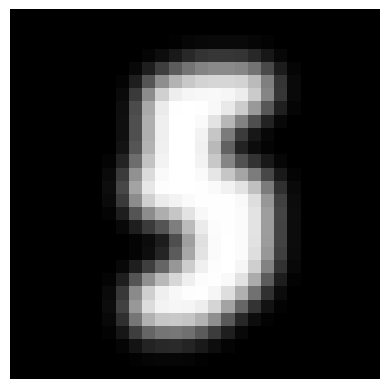

In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

# Load the MNIST expert model 11
model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
mnist_expert11 =load_model(model_path)

# Load a new image
image_path = "new_character2.JPG"
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(image_gray, (28, 28))
image_resized = 1 - (image_resized / 255.0)
image_resized[image_resized < 0.50] = 0
image_resized = cv2.medianBlur(np.float32(image_resized), 3)

# Apply various image processing techniques
kernel = np.ones((2, 2), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

kernel = np.ones((1, 3), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

# Predict using the loaded model
guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
print('Model 11 predicts:', np.argmax(guess))
print('Softmax outputs:', np.round(guess, 3))
print()

# Display the image
plt.imshow(image_resized, cmap='gray')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Model 11 predicts: 5
Softmax outputs: [[0.007 0.001 0.025 0.034 0.023 0.669 0.036 0.007 0.154 0.045]]



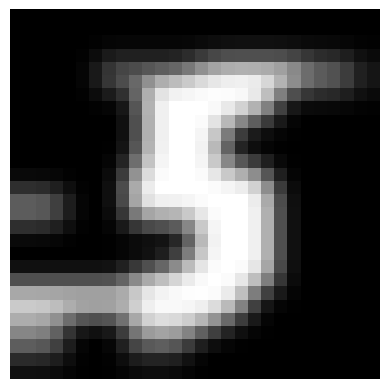

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

# Load the MNIST expert model 11
model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
mnist_expert11 =load_model(model_path)

# Load a new image
image_path = "new_character2.JPG"
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(image_gray, (28, 28))
image_resized = 1 - (image_resized / 255.0)
image_resized[image_resized < 0.50] = 0
image_resized[image_resized > 0.70] = 1

#image_resized = cv2.medianBlur(np.float32(image_resized), 3)
#image_resized = cv2.medianBlur(np.float32(image_resized), 3)
# Apply various image processing techniques
kernel = np.ones((2, 2), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

kernel = np.ones((1, 3), np.uint8)
image_resized = cv2.dilate(image_resized, kernel, iterations=2)
image_resized = cv2.erode(image_resized, kernel, iterations=1)
image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

# Predict using the loaded model
guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
print('Model 11 predicts:', np.argmax(guess))
print('Softmax outputs:', np.round(guess, 3))
print()

# Display the image
plt.imshow(image_resized, cmap='gray')
plt.axis('off')
plt.show()

# Vertex Finder

In [107]:
array = [
    [0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0.07943],
    [0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0.07943, 0, 0, 0, 0, 0.07943, 0, 0, 0.07943, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0.07943, 0, 0]
]


# Implementing Algorithm 1

L=F*Phi

Given:
* F - The belief network distributions
* Phi - How much it looks like each image

Solve:
* L - Which labels, and with what certainty

In [305]:
# # For each of the test images, create a vector sampling from a normal distribution
# # The mean is the average confidence score for each class for the test image, results[0, :, index]
# # The standard deviation is the average standard deviation for each class for the test image, results[1, :, index]
# # The length of the vector is the number of test images
# # Combine the vectors for each class into a matrix M of shape (10, number of test images)

# np.random.seed(123)

# # Assuming the `results` array is already populated as per your previous code
# num_classes = 10  # Number of classes
# num_images = len(test_images)  # Number of test images

# # Initialize the matrix M
# M = np.zeros((num_classes, num_images))

# # Populate the matrix
# for class_idx in range(num_classes):
#     for image_idx in range(num_images):
#         mean_confidence = results[0, class_idx, image_idx]  # Average confidence for this class & image
#         std_deviation = results[1, class_idx, image_idx]  # Standard deviation for this class & image
        
#         # Sample from a normal distribution with the computed mean and standard deviation
#         M[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)

# # M is now the matrix you wanted to compute
# print('The matrix M has the shape:', M.shape)

# # L is M matrix multiplied by phi
# L = M @ np.array(phi).reshape(-1, 1)

# print('The shape of phi is:', len(phi))
# print('The matrix L has the shape:', L.shape)


The matrix M has the shape: (10, 10000)
The shape of phi is: 10000
The matrix L has the shape: (10, 1)


In [31]:
# import numpy as np

# np.random.seed(123)  # Ensure reproducibility

# num_classes = 10  # Number of classes
# num_images = len(test_images)  # Assuming 'test_images' has been defined previously
# new_dim = 20  # The new dimension size

# # Step 1: Expand M to a 3D matrix
# # Initialize the expanded 3D matrix M_expanded
# M_expanded = np.zeros((num_classes, num_images, new_dim))

# for class_idx in range(num_classes):
#     for image_idx in range(num_images):
#         for new_idx in range(new_dim):
#             mean_confidence = results[0, class_idx, image_idx]
#             std_deviation = results[1, class_idx, image_idx]
#             # Resample for each new dimension
#             M_expanded[class_idx, image_idx, new_idx] = np.random.normal(mean_confidence, std_deviation)

# # Step 2: Adjust phi to new shape
# # Assuming 'phi' is defined as your SSIM values vector with shape (10000,)
# phi_expanded = np.tile(phi, (new_dim, 1)).T  # Transpose to get (10000, 20000)

# # Step 3: Compute new L
# # This step requires a bit of adjustment in how we think about matrix multiplication due to the shapes involved.
# # We perform the operation across the matching dimensions of M_expanded and phi_expanded.
# L = np.empty((num_classes, new_dim))

# for i in range(num_classes):
#     for j in range(new_dim):
#         # Here, we're essentially doing a dot product of each "slice" across all test images for a single class
#         L[i, j] = np.dot(M_expanded[i, :, j], phi_expanded[:, j])

# print('M_expanded shape:', M_expanded.shape)
# print('phi_expanded shape:', phi_expanded.shape)
# print('L shape:', L.shape)


M_expanded shape: (10, 10000, 20)
phi_expanded shape: (10000, 20)
L shape: (10, 20)


In [306]:
np.random.seed(1023)  # Ensure reproducibility

phi = ssim_values.copy()


# Assuming phi is a numpy array of shape (10000, 1)
def keep_top_k(phi, k):
    sorted_indices = np.argsort(-phi.flatten())  # Sort in descending order
    top_k_indices = sorted_indices[:k]
    phi_filtered = np.zeros_like(phi)
    phi_filtered[top_k_indices] = phi[top_k_indices]
    return phi_filtered

# Example usage:
k = 200  # Number of largest elements to keep
phi = keep_top_k(phi, k)

phi = phi/np.sum(phi)
initial_phi = phi.copy()

num_classes = 10  # Number of classes
num_images = len(test_images)  # Assuming 'test_images' has been defined previously
new_dim = 1000  # The new dimension size


# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
std_deviations = results[1, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)

# Use broadcasting to generate the new dimensions
phi_expanded = np.tile(phi, (new_dim, 1)).T 
M_expanded = np.random.normal(mean_confidences, std_deviations, (num_classes, num_images, new_dim))

# Compute L using einsum for efficient computation
L2 = np.einsum('ijk,jk->ik', M_expanded, phi_expanded)


#print('M_expanded shape:', M_expanded.shape)
#print('phi_expanded shape:', phi_expanded.shape)
#print('L shape:', L.shape)
print()

L2_avg = np.mean(L2, axis=1)
L2_std = np.std(L2, axis=1)

# Print the average L values for each class
# print('Average L2 values:', L2_avg)
# print()
# print('Standard Deviation L2 values:', L2_std)
print()
print(np.argmax(L2_avg))
print()

for idx in range(10):
    print(f'Class {idx}: ', L2_avg[idx]-L2_std[idx], L2_avg[idx]+L2_std[idx])




5

Class 0:  0.006613669499057572 0.010624803717968125
Class 1:  0.0036834363084226737 0.008588765933691272
Class 2:  0.017628046796708017 0.023288696572799476
Class 3:  0.3022275599470232 0.31378980409705526
Class 4:  0.0032582016308709827 0.008611669169728912
Class 5:  0.3173174643802176 0.33163205662405293
Class 6:  0.09068700592338338 0.09826666673732953
Class 7:  0.0015710197258132325 0.00467363888599744
Class 8:  0.161687465783088 0.17060855946618525
Class 9:  0.022551639777054443 0.02943170505013931


In [307]:
np.sum(phi)

0.9999999999999998

# Implementing Algorithm 2

L=F*Phi

Given:
* F - The belief network distributions
* L - Which labels, and with what certainty

Solve for:

* Phi - How much it looks like each image

Constaints:
* Each element of phi between 0 and 1
* Sum all elements of phi less than 1.

In [308]:
# Solve for Phi in the equation L = F * Phi

# Constaints:
# * Each element of phi between 0 and 1
# * Sum all elements of phi less than 1.


L = guess.copy()
L = L.reshape(10,)

F = np.zeros((num_classes, num_images)) # (10, 10000)
# Populate the matrix F
for class_idx in range(num_classes):
    for image_idx in range(num_images):
        mean_confidence = results[0, class_idx, image_idx]  # Average confidence for this class & image
        std_deviation = results[1, class_idx, image_idx]  # Standard deviation for this class & image
        
        F[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)

# Solve for Phi using the method of least squares
phi, residuals, rank, s = np.linalg.lstsq(F, L, rcond=None)

print('Phi:', phi)
print('Sum of Phi:', np.sum(phi))
print('sum of initial Phi:', np.sum(initial_phi))
print('Checking for negatives in phi', phi[np.argmin(phi)])


Phi: [2.66554154e-07 1.19696044e-05 3.03787421e-05 ... 1.75665487e-04
 4.80124642e-04 6.32155346e-06]
Sum of Phi: 1.0044718621689772
sum of initial Phi: 0.9999999999999998
Checking for negatives in phi -0.00017060111394180875


### Trying using SLSQP

In [36]:
# # Using the Sequential Least Squares Programming (SLSQP) method
# # Doesn't work

# # Objective function: Least squares difference
# def objective(phi):
#     return np.sum((F.dot(phi) - L)**2)

# # Constraint: Sum of phi elements < 1
# constraints = [{'type': 'ineq', 'fun': lambda phi: 1 - np.sum(phi)}]

# # Bounds: Each element of phi between 0 and 1
# bounds = [(0, 1) for _ in range(num_images)]

# result = minimize(objective, initial_phi, bounds=bounds, constraints=constraints)


## Trying using barrier Penalty Method

#### Monte Carlo Approach

Worst Case Error: 0.48431084
Best Error: 0.094497479929122


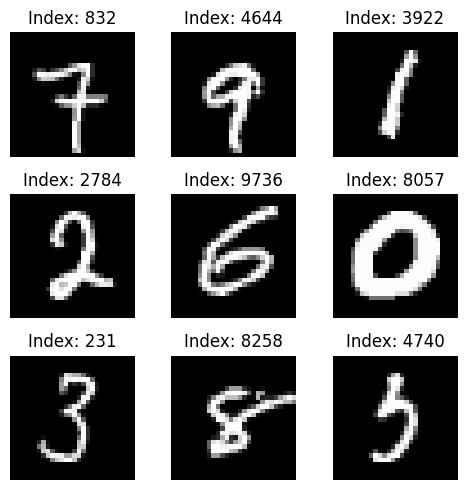

In [342]:
initial_phi = np.zeros(10000)
#initial_phi = ssim_values.copy()

# Calculate worst case error
error = np.linalg.norm(0 - guess)
print("Worst Case Error:", error)


# Defining some constants
num_classes = 10  
num_images = len(test_images)  
new_dim = 1000  


best_phi = np.zeros(10000)
best_error = error.copy()

# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :] 
std_deviations = results[1, :, :] 
M_expanded = np.random.normal(mean_confidences, std_deviations, (num_classes, num_images))

for _ in range(1_000_000):
    # Choose k random indices
    k = 15  # You can choose any value for k
    initial_phi = np.zeros(10000)
    random_indices = np.random.choice(len(initial_phi), k, replace=False)
    
    
    numbers = []
    numbers.append(np.random.uniform(0,1))
    for _ in range(k-1):
        numbers.append(np.random.uniform(0, 1 - np.sum(numbers)))

    
    initial_phi[random_indices] = numbers

    L2 = np.dot(M_expanded, initial_phi)

    # Calculate error
    error = np.linalg.norm(L2 - guess)

    if error< best_error:
        best_error = error.copy()
        best_phi= initial_phi.copy()

print("Best Error:", best_error)
#print("Best Phi:", best_phi)

# Plotting the 9 most similar images in a 3x3 grid
indices_of_most = np.argsort(best_phi)[-9:]

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.flat):
    ax.imshow(test_images[indices_of_most[idx]], cmap='gray')
    ax.set_title(f"Index: {indices_of_most[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


Once the phi is discovered, we can put it through F again, and determine L.

In [339]:

# Defining some constants
num_classes = 10  
num_images = len(test_images)  
new_dim = 1000  

phi_expanded = np.tile(best_phi, (new_dim, 1)).T  # Transpose to get (10000, new_dim)


# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
std_deviations = results[1, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
M_expanded = np.random.normal(mean_confidences, std_deviations, (num_classes, num_images, new_dim))

L3 = np.einsum('ijk,jk->ik', M_expanded, phi_expanded)


# print('M_expanded shape:', M_expanded.shape)
# print('phi_expanded shape:', phi_expanded.shape)
# print()
L3_avg = np.mean(L3, axis=1)
L3_std = np.std(L3, axis=1)


# print('Average L3 values:', L3_avg)
# print()

# print('Standard Deviation L3 values:', L3_std)
print()

for idx in range(10):
    print(f'Class {idx}: {(L3_avg[idx]-L3_std[idx]):.4g}, {L3_avg[idx]+L3_std[idx]:.4g}')

print(guess)
print(L3_avg)
print(sum(L3_avg))


Class 0: -0.03069, 0.1097
Class 1: -0.002273, 0.002203
Class 2: -0.001492, 0.0032
Class 3: 0.143, 0.1566
Class 4: 0.1213, 0.1451
Class 5: 0.3311, 0.4235
Class 6: -0.002169, 0.002376
Class 7: -0.001687, 0.006036
Class 8: 0.1468, 0.2885
Class 9: 0.02585, 0.06806
[[0.00170886 0.03895883 0.01871084 0.16308104 0.16178204 0.3932481
  0.01500941 0.01057794 0.15112421 0.04579876]]
[ 3.94911928e-02 -3.51323998e-05  8.54298550e-04  1.49792976e-01
  1.33177528e-01  3.77298520e-01  1.03550930e-04  2.17470099e-03
  2.17686238e-01  4.69537057e-02]
0.9674975784177481


## Averaging Several Good Vectors

Worst Case Error: 0.48431084
Best Error: 0.15062274757760008
Best Error: 0.18604277677444114
Best Error: 0.14071513708217315
Best Error: 0.18861324881461386
Best Error: 0.0958227442107615
Best Error: 0.13637950427255927
Best Error: 0.09499556451049827
Best Error: 0.12269028215147543
Best Error: 0.14801423995971955
Best Error: 0.1331533557770921
Best Error: 0.17036673708019404
Best Error: 0.16693416462804683
Best Error: 0.18553128273257752
Best Error: 0.12244088726452217
Best Error: 0.1305403677368622
Best Error: 0.17873443245722398
Best Error: 0.1436230810670404
Best Error: 0.15998082442476838
Best Error: 0.1731917520099005
Best Error: 0.1707163387557109
Best Error: 0.10828923757657337
Best Error: 0.1124994951344285
Best Error: 0.15584783979415154
Best Error: 0.18868240986102183
Best Error: 0.14207397718649944
Best Error: 0.11769679810657932
Best Error: 0.14692904006328183
Best Error: 0.09756640277726392
Best Error: 0.14324391990320795
Best Error: 0.1676116806328225
Best Error: 0.13567

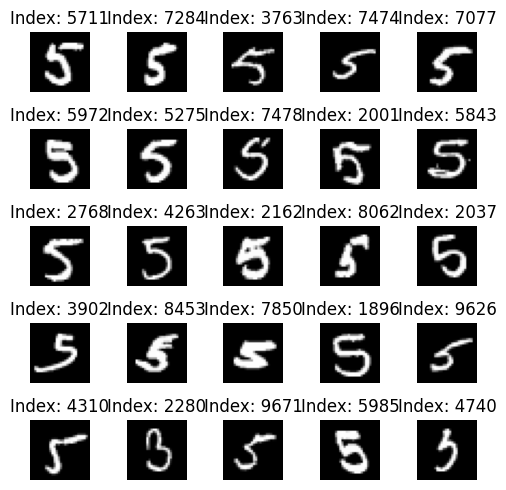

0.9975901862418994


In [467]:
initial_phi = np.zeros(10000)
#initial_phi = ssim_values.copy()

# Calculate worst case error
error = np.linalg.norm(0 - guess)
print("Worst Case Error:", error)


# Defining some constants
num_classes = 10  
num_images = len(test_images)  
new_dim = 1000  

alpha_phi = np.zeros(10000)

for _ in range(50):

    best_phi = np.zeros(10000)
    best_error = error.copy()

    # Generate random samples directly based on 'results'
    mean_confidences = results[0, :, :] 
    std_deviations = results[1, :, :] 
    M_expanded = np.random.normal(mean_confidences, std_deviations, (num_classes, num_images))

    for _ in range(5_000):
        # Choose k random indices
        k = 10  # You can choose any value for k
        initial_phi = np.zeros(10000)
        random_indices = np.random.choice(len(initial_phi), k, replace=False)
        
        
        numbers = []
        numbers.append(np.random.uniform(0,1))
        for _ in range(k-1):
            numbers.append(np.random.uniform(0, 1 - np.sum(numbers)))

        
        initial_phi[random_indices] = numbers

        L2 = np.dot(M_expanded, initial_phi)

        # Calculate error
        error = np.linalg.norm(L2 - guess) + 0.1*np.argmax(np.argmax(L2-guess),0)

        if error< best_error:
            best_error = error.copy()
            best_phi= initial_phi.copy()

    print("Best Error:", best_error)
    #print("Best Phi:", best_phi)
    alpha_phi += best_phi


alpha_phi = alpha_phi/50
# Plotting the 9 most similar images in a 3x3 grid
indices_of_most = np.argsort(alpha_phi)[-25:]

fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for idx, ax in enumerate(axes.flat):
    ax.imshow(test_images[indices_of_most[idx]], cmap='gray')
    ax.set_title(f"Index: {indices_of_most[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

print(np.sum(alpha_phi))


In [468]:

# Defining some constants
num_classes = 10  
num_images = len(test_images)  
new_dim = 200  

phi_expanded = np.tile(alpha_phi, (new_dim, 1)).T  # Transpose to get (10000, new_dim)


# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
std_deviations = results[1, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
M_expanded = np.random.normal(mean_confidences, std_deviations, (num_classes, num_images, new_dim))

L3 = np.einsum('ijk,jk->ik', M_expanded, phi_expanded)


# print('M_expanded shape:', M_expanded.shape)
# print('phi_expanded shape:', phi_expanded.shape)
# print()
L3_avg = np.mean(L3, axis=1)
L3_std = np.std(L3, axis=1)


# print('Average L3 values:', L3_avg)
# print()

# print('Standard Deviation L3 values:', L3_std)
print()

for idx in range(10):
    print(f'Class {idx}: {(L3_avg[idx]-L3_std[idx]):.4g}, {L3_avg[idx]+L3_std[idx]:.4g}')

print(guess)
print(L3_avg)
print(sum(L3_avg))


Class 0: 0.009808, 0.01743
Class 1: 0.0209, 0.02287
Class 2: 0.01817, 0.02223
Class 3: 0.1461, 0.164
Class 4: 0.1518, 0.1593
Class 5: 0.399, 0.4218
Class 6: 0.01763, 0.02135
Class 7: 0.0137, 0.01787
Class 8: 0.1132, 0.1244
Class 9: 0.02472, 0.0342
[[0.00170886 0.03895883 0.01871084 0.16308104 0.16178204 0.3932481
  0.01500941 0.01057794 0.15112421 0.04579876]]
[0.01361685 0.02188487 0.0201968  0.15501857 0.1555411  0.41040137
 0.01948957 0.01578526 0.1187899  0.02946473]
0.960189019283996


In [469]:
print(L3_avg)
print(guess)
print(guess-L3_avg)

[0.01361685 0.02188487 0.0201968  0.15501857 0.1555411  0.41040137
 0.01948957 0.01578526 0.1187899  0.02946473]
[[0.00170886 0.03895883 0.01871084 0.16308104 0.16178204 0.3932481
  0.01500941 0.01057794 0.15112421 0.04579876]]
[[-0.01190798  0.01707396 -0.00148596  0.00806246  0.00624094 -0.01715326
  -0.00448017 -0.00520732  0.03233431  0.01633403]]


In [350]:

# Defining some constants
num_classes = 10  
num_images = len(test_images)  
new_dim = 1000  

phi_expanded = np.tile(alpha_phi/10, (new_dim, 1)).T  # Transpose to get (10000, new_dim)


# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
std_deviations = results[1, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
M_expanded = np.random.normal(mean_confidences, std_deviations, (num_classes, num_images, new_dim))

L3 = np.einsum('ijk,jk->ik', M_expanded, phi_expanded)

L3_avg = np.mean(L3, axis=1)
L3_std = np.std(L3, axis=1)



print()

for idx in range(10):
    print(f'Class {idx}: {(L3_avg[idx]-L3_std[idx]):.4g}, {L3_avg[idx]+L3_std[idx]:.4g}')

print(guess)
print(L3_avg)
print(sum(L3_avg))


Class 0: 0.001266, 0.001495
Class 1: 0.00171, 0.001849
Class 2: 0.001265, 0.001444
Class 3: 0.01506, 0.01578
Class 4: 0.0147, 0.01521
Class 5: 0.04075, 0.04192
Class 6: 0.001241, 0.001479
Class 7: 0.001015, 0.001124
Class 8: 0.01406, 0.01482
Class 9: 0.003021, 0.003397
[[0.00170886 0.03895883 0.01871084 0.16308104 0.16178204 0.3932481
  0.01500941 0.01057794 0.15112421 0.04579876]]
[0.00138037 0.00177986 0.00135453 0.01541815 0.01495444 0.04133289
 0.00136018 0.00106983 0.01444216 0.00320898]
0.09630138582263997


In [24]:
import numpy as np

# Coefficients matrix
A = np.array([[0.8, 0.9, 0.7],
              [0.2, 0.1, 0.3]])

# Constants vector
B = np.array([0.15, 0.85])

# Solve the system of equations using least squares
solution, residuals, _, _ = np.linalg.lstsq(A, B, rcond=None)

print("Solution:")
print("x1 =", solution[0])
print("x2 =", solution[1])
print("x3 =", solution[2])

x1 = solution[0]
x2 = solution[1]
x3 = solution[2]
# Given equations
eq1 = 0.8 * x1 + 0.9 * x2 + 0.7 * x3
eq2 = 0.2 * x1 + 0.1 * x2 + 0.3 * x3

# Print the evaluated equations
print("Evaluated Equations:")
print("0.8*x1 + 0.9*x2 + 0.7*x3 = ", eq1)
print("0.2*x1 + 0.1*x2 + 0.3*x3 = ", eq2)

best_error = 10000;

for _ in range(1_00_000):
        k = 3  # You can choose any value for k
        initial_phi = np.zeros(3)
        random_indices = np.random.choice(len(initial_phi), k, replace=False)
        
        
        numbers = []
        numbers.append(np.random.uniform(0,1))
        for _ in range(k-1):
            numbers.append(np.random.uniform(0, 1 - np.sum(numbers)))
        
        initial_phi[random_indices] = numbers

        initial_phi[2] = 1-(initial_phi[0]+initial_phi[1])

        L2 = np.dot(A, initial_phi)

        # Calculate error
        error = np.linalg.norm(L2 - B)

        if error< best_error:
            best_error = error.copy()
            best_phi= initial_phi.copy()

print()
print('best phi', best_phi)

x1 = best_phi[0]
x2 = best_phi[1]
x3 = best_phi[2]
# Given equations
eq1 = 0.8 * x1 + 0.9 * x2 + 0.7 * x3
eq2 = 0.2 * x1 + 0.1 * x2 + 0.3 * x3

# Print the evaluated equations
print("MonteCarlo Solutions to Equations:")
print("0.8*x1 + 0.9*x2 + 0.7*x3 = ", eq1)
print("0.2*x1 + 0.1*x2 + 0.3*x3 = ", eq2)



Solution:
x1 = 0.3333333333333325
x2 = -2.9166666666666656
x3 = 3.5833333333333326
Evaluated Equations:
0.8*x1 + 0.9*x2 + 0.7*x3 =  0.1499999999999999
0.2*x1 + 0.1*x2 + 0.3*x3 =  0.8499999999999996

best phi [3.24023139e-06 2.37308045e-06 9.99994387e-01]
MonteCarlo Solutions to Equations:
0.8*x1 + 0.9*x2 + 0.7*x3 =  0.7000007986392298
0.2*x1 + 0.1*x2 + 0.3*x3 =  0.2999992013607702


In [32]:
import numpy as np
from scipy.optimize import minimize

# Coefficients matrix
A = np.array([[0.8, 0.9, 0.7],
              [0.2, 0.1, 0.3]])

# Constants vector
B = np.array([0.15, 0.85])

# Define the objective function (to minimize)
def objective_function(x):
    return np.linalg.norm(np.dot(A, x) - B)

# Define the constraint function (x1, x2, x3 must be positive)
def constraint(x):
    return x

# Define the bounds for x1, x2, x3 (positive values)
bounds = [(0, None), (0, None), (0, None)]

# Solve the system of equations using constrained optimization
result = minimize(objective_function, x0=np.zeros(3), method='SLSQP', bounds=bounds, constraints={'type': 'ineq', 'fun': constraint})

# Extract the solution
solution = result.x

print("Solution:")
print("x1 =", solution[0])
print("x2 =", solution[1])
print("x3 =", solution[2])

# Evaluate the equations using the solution
eq1 = 0.8 * solution[0] + 0.9 * solution[1] + 0.7 * solution[2]
eq2 = 0.2 * solution[0] + 0.1 * solution[1] + 0.3 * solution[2]

print("Evaluated Equations:")
print("0.8*x1 + 0.9*x2 + 0.7*x3 = ", eq1)
print("0.2*x1 + 0.1*x2 + 0.3*x3 = ", eq2)

error = np.linalg.norm([eq1,eq2] - B)
print('error = ', error)


best_error = 10000;
best_phi = [0]

for _ in range(1_000_000):
        k = 3  # You can choose any value for k
        initial_phi = np.zeros(3)
        random_indices = np.random.choice(len(initial_phi), k, replace=False)
        
        
        numbers = []
        numbers.append(np.random.uniform(0,1))
        for _ in range(k-1):
            numbers.append(np.random.uniform(0, 1 - np.sum(numbers)))
        
        initial_phi[random_indices] = numbers

        #initial_phi[2] = 1-(initial_phi[0]+initial_phi[1])

        L2 = np.dot(A, initial_phi)

        # Calculate error
        error = np.linalg.norm(L2 - B)

        if error< best_error:
            best_error = error.copy()
            best_phi= initial_phi.copy()

print()
print('best phi', best_phi)

x1 = best_phi[0]
x2 = best_phi[1]
x3 = best_phi[2]
# Given equations
eq1 = 0.8 * x1 + 0.9 * x2 + 0.7 * x3
eq2 = 0.2 * x1 + 0.1 * x2 + 0.3 * x3

# Print the evaluated equations
print("MonteCarlo Solutions to Equations:")
print("0.8*x1 + 0.9*x2 + 0.7*x3 = ", eq1)
print("0.2*x1 + 0.1*x2 + 0.3*x3 = ", eq2)
print('error = ', best_error)


Solution:
x1 = 8.243139340288087e-17
x2 = 0.0
x3 = 0.6206848911303665
Evaluated Equations:
0.8*x1 + 0.9*x2 + 0.7*x3 =  0.4344794237912566
0.2*x1 + 0.1*x2 + 0.3*x3 =  0.18620546733910998
error =  0.7221853807375879

best phi [4.39641638e-03 3.75779879e-04 6.23445813e-01]
MonteCarlo Solutions to Equations:
0.8*x1 + 0.9*x2 + 0.7*x3 =  0.44026740409819076
0.2*x1 + 0.1*x2 + 0.3*x3 =  0.18795060516453957
error =  0.7228862753461998


# Appendix

### Convolution of triangles

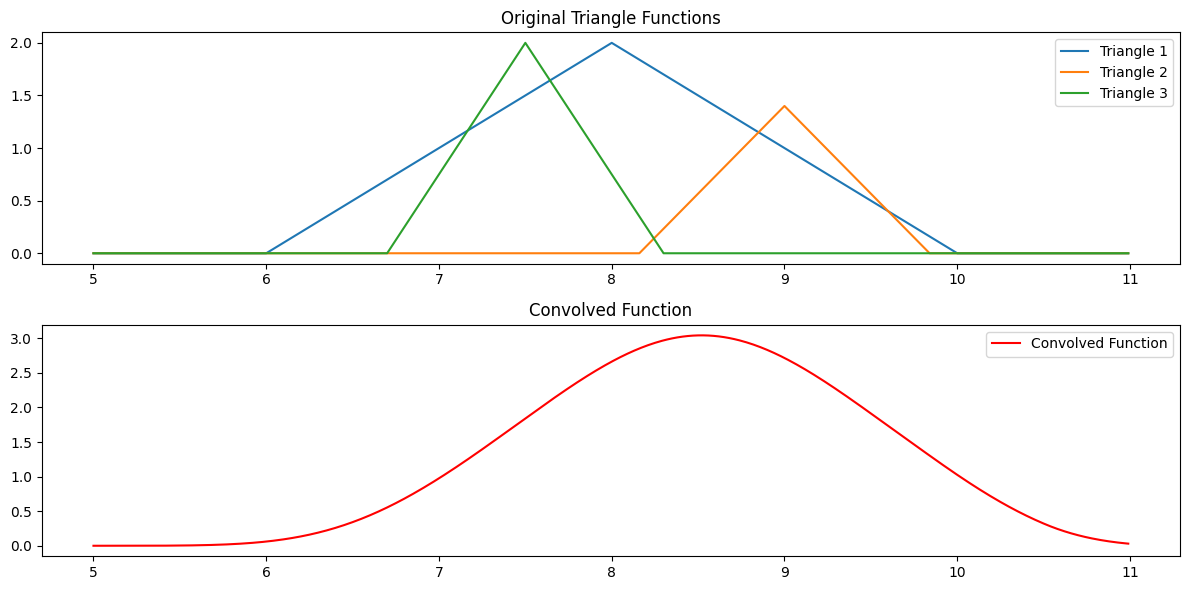

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the discretization step
dx = 0.01

# Define the ranges for the functions
x = np.arange(5, 11, dx)

# Define the first triangle function, centered at 8.0, height=1, width=2
def triangle(x, center, width, height):
    return np.maximum(height - np.abs(x - center) / (width / 2), 0)


# Calculate the triangle functions
y1 = triangle(x, 8, 2, 2)
y2 = triangle(x,9,1.2,1.4)
y3 = triangle(x,7.5,0.8,2)
# Perform the convolution
y_convolved = np.convolve(y1, y2, mode='same') * dx
y_convolved_again = np.convolve(y_convolved, y3, mode='same') * dx


# Adjust the x-axis for the convolution result to match its length
x_convolved = np.linspace(x.min(), x.max(), len(y_convolved_again))

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(x, y1, label='Triangle 1')
plt.plot(x, y2, label='Triangle 2')
plt.plot(x, y3, label='Triangle 3')
plt.title('Original Triangle Functions')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x_convolved, y_convolved_again, color='red', label='Convolved Function')
plt.title('Convolved Function')
plt.legend()

plt.tight_layout()
plt.show()


### Combining Triangles as a Triangle

### Getting Most Similar images via SSIM

https://en.wikipedia.org/wiki/Structural_similarity_index_measure#Algorithm




In [18]:
# For each Image Index
#     For each Model/Classifier
#         Print the Scaled Confidence Score of each possible class (Confidence Score * the model's accuracy)
#         Calculate error bounds [a,b] as +/- 1.96 * sqrt(p(1-p)/n) where p = model accuracy, n = number of samples
#         Determine width of the triangle at the error bounds = (b - a)*confidence score
#         Determine height at confidence score = 2/width
        
        
#     Aggregate the heights and widths and confidence score of the models for each class
# Return the image index, average confidence score, the average height and the average width for each class


# Initialize variables
n = 10000 # Number of samples
accuracies = scores[1:5]  # Assuming scores is a list of accuracies for each model
z_score = 1.96  # Z-score for 95% confidence interval
# Calculate the standard error for each model
standard_deviations = np.sqrt(accuracies * (1 - accuracies) / n)  # Standard deviation for each model

# error_bounds = z_score * np.sqrt(accuracies * (1 - accuracies) / n) # Calculate error bounds for each model

softmax_outputs = [model.predict(test_images), model2.predict(test_images), model3.predict(test_images),
                   model4.predict(test_images), model5.predict(test_images)]

# Initialize a 3D array to store the results # Shape: (3 metrics, 10 classes, number of images)
results = np.zeros((3, 10, len(test_images)))  

# For each Image
for index in range(len(test_images)):  # Assuming test_images is defined
    for class_idx in range(10):  # Assuming 10 classes
        total_confidence = 0
        total_heights = 0
        total_widths = 0
        
        for i, softmax_output in enumerate(softmax_outputs):
            confidence_score = softmax_output[index, class_idx]  # Confidence score for this class from the i-th model
            scaled_confidence = confidence_score * accuracies[i]  # Scaled confidence score
            
            width = 2 * error_bounds[i]*confidence_score # Width of the triangle at the error bounds
            height = 2 / width  # Height at confidence score
            
            total_confidence += scaled_confidence
            total_heights += height
            total_widths += width
        
        # Calculate averages for this class for this image
        avg_confidence = total_confidence / len(softmax_outputs)
        avg_height = total_heights / len(softmax_outputs)
        avg_width = total_widths / len(softmax_outputs)
        
        # Store the averages in the results array
        results[0, class_idx, index] = avg_confidence
        results[1, class_idx, index] = avg_height
        results[2, class_idx, index] = avg_width

# Example: Print the results for the first image across all classes for each metric
print(f"Average Confidence Scores for Image 0: {results[0, :, 0]}")
print(f"Average Heights for Image 0: {results[1, :, 0]}")
print(f"Average Widths for Image 0: {results[2, :, 0]}")



TypeError: unsupported operand type(s) for -: 'int' and 'list'

Highest SSIM index: 85, SSIM Value: 0.00044445275803480986


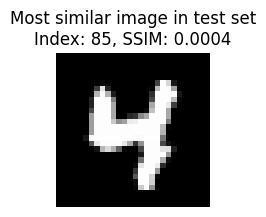

0.9999999999999999


In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
import cv2


# Placeholder for SSIM scores
ssim_scores = []

# Iterate over each test image
for test_image in test_images:
    # Resize the test image to 28x28
    test_image = cv2.resize(test_image, (28, 28))
    ssim = compare_ssim(image_resized, test_image, data_range=test_image.max() - test_image.min())
    ssim_scores.append(ssim)

# Find the index of the test image with the highest SSIM score

ssim_scores = ssim_scores/np.sum(ssim_scores) # Make this a probability distribution
max_ssim_index = np.argmax(ssim_scores)
max_ssim_value = ssim_scores[max_ssim_index]

print(f"Highest SSIM index: {max_ssim_index}, SSIM Value: {max_ssim_value}")

# If needed, display the most similar image
plt.figure(figsize=(2, 2))
plt.imshow(test_images[max_ssim_index], cmap='gray')
plt.title(f"Most similar image in test set\nIndex: {max_ssim_index}, SSIM: {max_ssim_value:.4f}")
plt.axis('off')
plt.show()

y=np.sum(ssim_scores)
print(y)


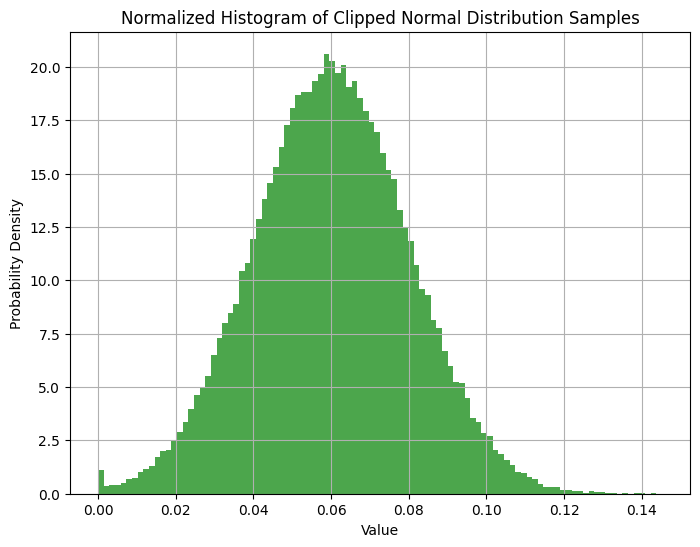

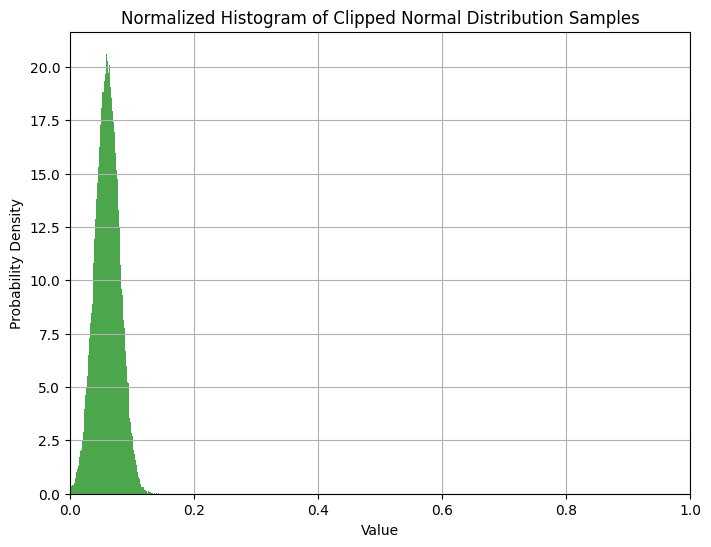

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 0.06
sigma = 0.02
n_samples = 100000

# Generating samples
samples = np.random.normal(mu, sigma, n_samples)

# Clipping samples
clipped_samples = np.clip(samples, 0, 1)


# Plotting normalized histogram
plt.figure(figsize=(8, 6))
plt.hist(clipped_samples, bins=100, color='green', alpha=0.7, density=True)
plt.title('Normalized Histogram of Clipped Normal Distribution Samples')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


# Plotting normalized histogram
plt.figure(figsize=(8, 6))
plt.hist(clipped_samples, bins=100, color='green', alpha=0.7, density=True)
plt.title('Normalized Histogram of Clipped Normal Distribution Samples')
plt.xlabel('Value')
plt.xlim(0, 1)  # Setting the x-axis limits to [0, 1]
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()
